In [1]:
import numpy as np
import pandas as pd
import scipy.stats as st
from scipy.stats import norm, uniform, randint
from tensorflow.keras.utils import Progbar as ProgressBar

import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline
plt.ioff()
sns.set()

from functools import partial

pd.options.display.max_rows = 999

from math import log

## Section 2.6 – Exercise 2.6
The case of the Mysterious Spikes

Explain the pattern observed with optimistic priors on the 10-armed bandit problem. See Sutton and Barto for context and notation (e.g. q_star, epsilon_greediness, etc)

In [25]:
class SlotMachine:
  
  def __init__(self):
    self.q_star = norm.rvs(0, 1) # mean/variance
    self.reward = norm(self.q_star, 1)
    
  def play(self):
    return self.reward.rvs()

In [26]:
class Casino:
  
  def __init__(self, num_machines):
    self.k        = num_machines
    self.reset()
    
  def reset(self):
    self.machines = [SlotMachine() for _ in range(self.k)]
    self.q_stars  = np.array([machine.q_star for machine in self.machines])
    self.optimal_machine = self.q_stars.argmax()
    
  def __getitem__(self,index):
    return self.machines[index]
  
  def __len__(self):
    return self.k
  
  def play(self, index):
    return self.machines[index].play()


In [27]:
class Bandit:
  
  def __init__(self, casino, epsilon_greediness, lr = lambda n, t : 1/n, priors = None):
    self.priors = priors
    self.epsilon = epsilon_greediness
    self._lr     = lr
    self.reset(casino)

  def reset(self, casino):
    if self.priors is None:
      self.q_star_estimates  = [0.0] * len(casino)
    else:
      self.q_star_estimates  = self.priors.copy()
      
    self.casino = casino
    self.q_star_estimates = np.array(self.q_star_estimates)
    self.t       = 0
    self.num_times_played = [0] * len(casino)
    self.rewards = []
    self._rand_machine = randint(0, len(casino))

    
  def lr(self, machine):
    n = self.num_times_played[machine] + 1
    t = self.t
    return self._lr(n, t)
    
  def rand_machine(self):
    return self._rand_machine.rvs()
    
  def choose_machine(self):
    if uniform.rvs() < self.epsilon:
      machine = self.rand_machine()
    else:
      machine = self.q_star_estimates.argmax()
      
    return machine
      
  def play_machine(self, machine = None):
    if machine is None:
      machine = self.choose_machine()
      
    reward = casino.play(machine)
    self.rewards.append(reward)
    
    lr = self.lr(machine)
    
    self.num_times_played[machine] += 1
    self.t += 1
    
    q_n = self.q_star_estimates[machine]
    self.q_star_estimates[machine] = q_n + lr * (reward - q_n)
    
    return machine, reward

In [43]:
class Simulator:
  
  def __init__(self, bandits, casino, time = 1000, num_runs = 2000, burn_in = False):
    self.time     = time
    self.num_runs = num_runs
    self.burn_in  = burn_in
    self.bandits      = []
    self.bandit_names = []
    for bandit_name, bandit in bandits.items():
      self.bandit_names.append(bandit_name)
      self.bandits.append(bandit)
    
    self.casino   = casino
    
    self.optimal_machine = [[] for _ in range(len(self.bandits))]
    self.rewards         = [[] for _ in range(len(self.bandits))]
    self.data = {}
    
  def run_bandit(self, bandit_index):
    
    optimal_machine = []
    rewards         = []
    bandit          = self.bandits[bandit_index]
          
    for t in range(self.time):
      if self.burn_in and t < len(casino):
        machine, reward = bandit.play_machine(machine = t)
      else:
        machine, reward = bandit.play_machine()
        
      rewards.append(reward)
      optimal_machine.append(machine == casino.optimal_machine)
    
    self.optimal_machine[bandit_index].append(optimal_machine)
    self.rewards[bandit_index].append(rewards)
    
  def run_bandits(self):
    for bandit_index in range(len(self.bandits)):
      self.run_bandit(bandit_index)
      
  def run(self):
    bar = ProgressBar(self.num_runs)
    for _ in range(self.num_runs):
      self.casino.reset()
      for bandit in self.bandits:
        bandit.reset(casino)
      self.run_bandits()
      bar.add(1)
      
    return self
  
  def _collate_data(self, dv = 'reward'):
    if dv not in ['reward', 'optimality']:
      return ValueError('Choose reward or optimality')
    
    if dv == 'reward':
      data = self.rewards
    elif dv == 'optimality':
      data = self.optimal_machine
      
    data = np.array(data)
    data = data.mean(axis = 1)
    
    df = pd.DataFrame(data.T, columns = self.bandit_names, index = pd.RangeIndex(1, self.time+1, name = 'time'))
    self.data[dv] = df
        
  def _plot(self, dv, df):
    df = df.reset_index()
    df = df.melt(id_vars = 'time', var_name = 'strategy', value_name = dv)

    fig, ax = plt.subplots()
    sns.lineplot(x = 'time', y = dv, hue = 'strategy', data = df, ax = ax)
    ax.set_title(dv)
    return fig

  def plot(self, dv = 'reward'):
    self._collate_data(dv)
    return self._plot(dv, self.data[dv])
  
  def plots(self):
    sim.plot('reward')
    sim.plot('optimality')
    plt.show()

2000/2000 [==============================] - 758s 379ms/step


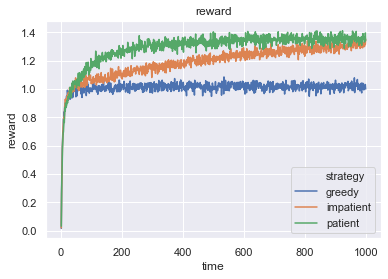

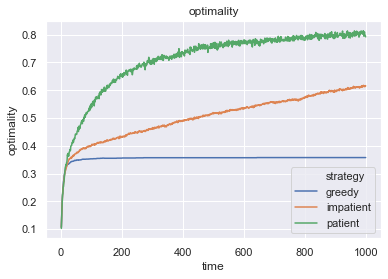

In [13]:
casino = Casino(10)
bandits = {
  'greedy'    : Bandit(casino, 0),
  'impatient' : Bandit(casino, 0.01),
  'patient'   : Bandit(casino, 0.1)
}

# Figure 2.2 (page 29)
sim = Simulator(bandits, casino, num_runs = 2000).run()
sim.plots()

2000/2000 [==============================] - 1632s 816ms/step


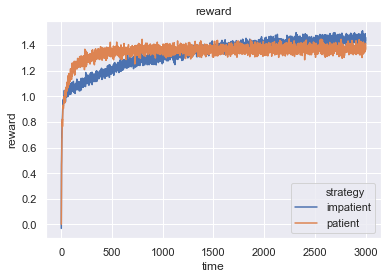

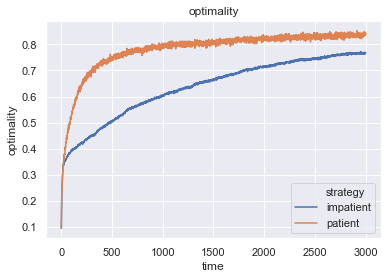

In [57]:
casino = Casino(10)
bandits = {
  'impatient' : Bandit(casino, 0.01),
  'patient'   : Bandit(casino, 0.1)
}

# Figure 2.2 (page 29)
sim = Simulator(bandits, casino, time = 3000, num_runs = 2000).run()
sim.plots()

### Optimistic Prior

2000/2000 [==============================] - 512s 256ms/step


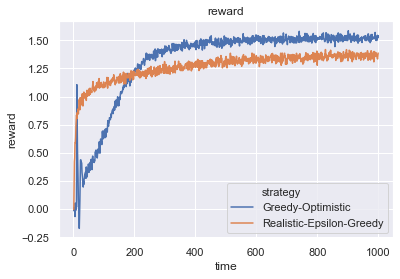

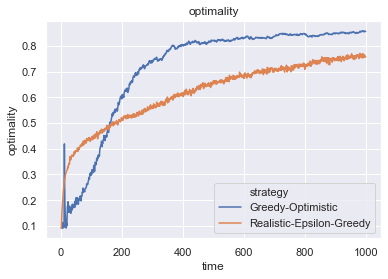

In [55]:
casino = Casino(10)
prior  = [5.0] * 10
lr = lambda n, t : 0.1
bandits = {
  'Greedy-Optimistic'          : Bandit(casino, 0   ,lr = lr, priors = prior),
  'Realistic-Epsilon-Greedy'   : Bandit(casino, 0.1 ,lr = lr)
}

# Figure 2.3 (page 35)
sim = Simulator(bandits, casino, num_runs = 2000).run()
sim.plots()

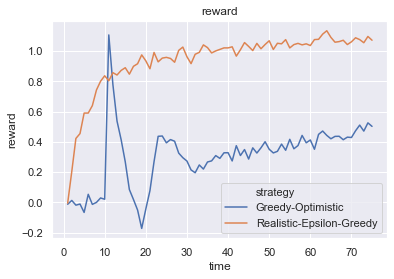

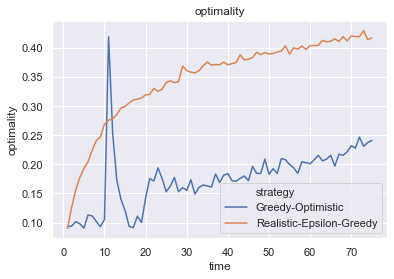

In [56]:
zoom = 75
fig_1 = sim._plot('reward', sim.data['reward'][:zoom])
fig_2 = sim._plot('optimality', sim.data['optimality'][:zoom])
plt.show()

# Section 4.4 – Value Iteration. The Gambler's Ruin (exercise 4.9)
There is a coin with win probability p_h (heads) and the gambler can either double their stake or lose it all on each flip. The crucial difference is that the gambler can choose the stakes. Money is quantized and a sunk cost. Gambler wins at 100, loses at 0.

Solution: for p > 0.5, the optimal strategy is to always bet $1 and count on the law of large numbers. Convergence is very slow. An exact solution is given at the end.

Consider the analytic continuation (morally) and take the Taylor expansion to second order. Take p = 0.55 for concreteness.

\begin{align*}
f(a + x) = f(a) + f'(a)x + \frac{f''(a)x^2}{2} + \frac{f'''(a)x^3}{6}.
\end{align*}

If the policy is k, then update is, away from boundaries, to

\begin{align*}
0.55f(a + k) + 0.45f(a - k) 
&= f(a) + f'(a)\left[0.55k - 0.45k\right] + \frac{f''(a)}{2}\left[0.55k^2 + 0.45k^2\right] \\
&= f(a) + 0.1 f'(a) k + \frac{f''(a)k^2}{2}
\end{align*}

The optimal k is given when
\begin{align*}
0 &= 0.1f'(a) + f''(a)k \\[1em]
\Rightarrow k &= -0.1f'(a)/f''(a)
\end{align*}

This is a problem because our initial solutions all have low curvature by simplicity, and also this measure is quite sensitive.

For p = 0.5 an unbiased random walk., the solution is given by the standard theory of stochastic processes and is just a linear interpolation from 0 to 100.

States are 1–99. The terminal state is aliased as 0, 100 or 'TERMINAL' for convenience

In [3]:
class ValueFunction:

  def __init__(self, values = None):
    if values is None:
      values = np.zeros(99)
    
    self.values = values
    
  def __setitem__(self, key, val):
    self.values[key - 1] = val
    
  def __getitem__(self, key):
    assert int(key) == key
    return self.values[int(key) - 1]
  
  def __call__(self, state):
    if state in [0, 100, 'TERMINAL']:
      return 0
    else:
      return self[state]
    
  @property
  def states(self):
    return range(1, 100)

In [55]:
def transitions(p_heads, state):
  '''Returns the set of possible
  actions, resulting states, rewards, and
  probability of the resulting state and reward conditional on the action
  State is either TERMINAL or 1–99.
  
  Returns a dataframe
  '''
  tolerance      = 10**(-2)
  
  if state in [0, 100, 'TERMINAL']:
    return [(0, 'TERMINAL', terminal_value, 1)]
  
  transitions      = []
  possible_actions = min(state, 100-state)
  
  for action in range(1, possible_actions + 1):
    if state + action == 100:
      success_reward = 1
    else:
      success_reward = 0
      
    failure_reward   = 0
      
    transitions += [
      (action, state + action, success_reward,     p_heads),
      (action, state - action, failure_reward, 1 - p_heads)
    ]

  transitions = pd.DataFrame(transitions, columns = ['action', 'new_state', 'reward', 'probability'])
    
  return transitions

In [134]:
class ValueIteration:
  
  def __init__(self, p_heads, value_function, tolerance = 10**(-9)):
    self.p_h            = p_heads
    self.transitions    = partial(transitions, p_heads)
    self.value_function = value_function
    
    self.value_fn_data  = []
    self.record_value_function()
    self.tolerance = tolerance

  def record_value_function(self):
    self.value_fn_data.append(self.value_function.values.copy())
    
  def _action_ev(self, state):
    # Compute the expected return from each action
    df = self.transitions(state)

    # Lookup the new state values
    df = df.assign(v_new_state    = df.apply(
      lambda row : self.value_function(row.new_state)
      , axis = 'columns')
    )

    # Compute the discounted value of the action/result combination
    df = df.assign(discounted_val = 
      df.apply(lambda row : (row.reward + row.v_new_state) * row.probability,
      axis = 'columns')
    )

    # Compute the expected value of the action
    df = df.groupby('action').discounted_val.sum()
    
    return df

  def step(self):
    '''Updates are made in place'''
    for state in value_function.states:
      df = self._action_ev(state)
      
      # Choose the optimal action
      new_value = df.max()
      
      value_function[state] = new_value
    
    self.record_value_function()
    
  def run(self, max_steps = 100):
    print(f'Delta is the log base 10 of the sup norm of the change in the value function')
    bar = ProgressBar(max_steps, stateful_metrics = ['delta'])
    for _ in range(max_steps):
      self.step()
      # Test for convergence
      sup_norm = abs(self.value_fn_data[-1] - self.value_fn_data[-2]).max()
      
      if sup_norm < self.tolerance:
        bar.target = bar._seen_so_far + 1
      
      bar.add(1, [('delta', log(sup_norm) / log(10))])
      
      if sup_norm < self.tolerance:
        break

        
  def optimal_action(self, state):
    return self._action_ev(state).idxmax()
  
  def policy(self):
    return pd.DataFrame([(state, optimizer.optimal_action(state)) for state in value_function.states], columns = ['state', 'action'])
  
  def plot_actions(self):
    fig, ax = plt.subplots()
    df = self.policy()
    sns.scatterplot(x = 'state', y = 'action', data = df, ax = ax)
    return fig
  
  def plot_value_functions(self, steps = None):
    if steps is None:
      steps = list(range(len(self.value_fn_data)))
      
    df = np.array(optimizer.value_fn_data).T[:, steps]
    
    df = pd.DataFrame(df, index = pd.Index(self.value_function.states, name = 'state'))
    df = df.reset_index().melt(id_vars = 'state', var_name = 'step')
    df['step'] = df.step.apply(lambda s : f'Step {steps[s]}')
    fig, ax = plt.subplots()
    sns.lineplot(x = 'state', y = 'value', hue = 'step', data = df, ax = ax)
    return fig


Delta is the log base 10 of the sup norm of the change in the value function
11/11 [==============================] - 13s 1s/step - delta: -5.5781


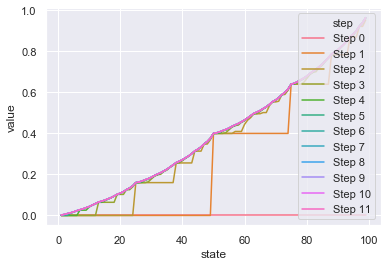

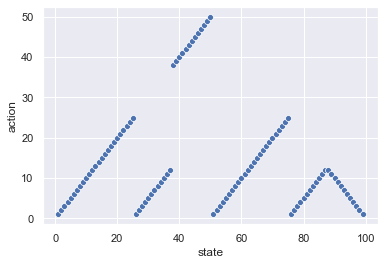

In [109]:
value_function = ValueFunction()
optimizer      = ValueIteration(0.4, value_function, tolerance = 10**(-5))

optimizer.run()
fig_1 = optimizer.plot_value_functions()
fig_2 = optimizer.plot_actions()
plt.show()

Delta is the log base 10 of the sup norm of the change in the value function
51/51 [==============================] - 68s 1s/step - delta: -3.0035   


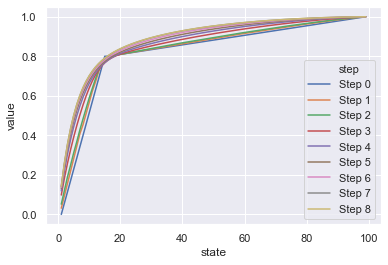

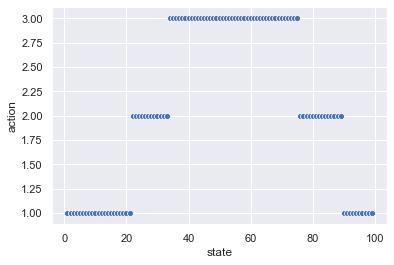

In [128]:
breakpoint = 15
breakvalue = 0.8
initial_values = np.concatenate([np.linspace(0, breakvalue, breakpoint), np.linspace(breakvalue, 1, 99 - breakpoint)])
max_steps = 1000

value_function = ValueFunction(initial_values)
optimizer      = ValueIteration(0.55, value_function, tolerance = 10**(-3))

optimizer.run(max_steps)
num_steps = len(optimizer.value_fn_data)
steps = list(filter(lambda n : n < num_steps, range(10, max_steps, 10)))
steps = [0, 1, 2] + steps + [-1]

fig_1 = optimizer.plot_value_functions(steps)
fig_2 = optimizer.plot_actions()
plt.show()

Delta is the log base 10 of the sup norm of the change in the value function
100/100 [==============================] - 160s 2s/step - delta: -3.0989


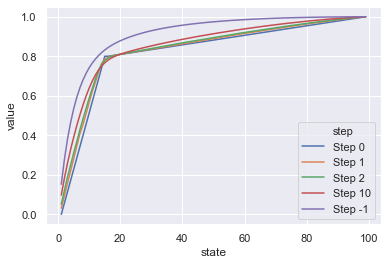

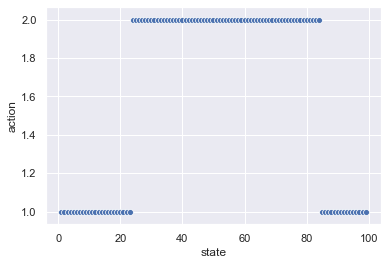

In [168]:
breakpoint = 15
breakvalue = 0.8
initial_values = np.concatenate([np.linspace(0, breakvalue, breakpoint), np.linspace(breakvalue, 1, 99 - breakpoint)])
max_steps = 100

value_function = ValueFunction(initial_values)
optimizer      = ValueIteration(0.55, value_function, tolerance = 10**(-5))

optimizer.run(max_steps)
num_steps = len(optimizer.value_fn_data)
steps = list(filter(lambda n : n < num_steps, range(10, max_steps, max_steps // 10)))
steps = [0, 1, 2] + steps + [-1]

fig_1 = optimizer.plot_value_functions(steps)
fig_2 = optimizer.plot_actions()
plt.show()

Delta is the log base 10 of the sup norm of the change in the value function
100/100 [==============================] - 138s 1s/step - delta: -2.7623


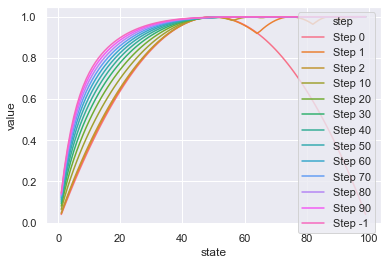

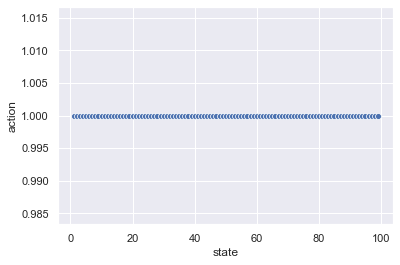

In [173]:
# Force the correct policy by having high curvature!
initial_values = np.array([1 - 4 * (x - 0.5)**2 for x in np.arange(0.01, 1.00, 0.01)])

max_steps = 100

value_function = ValueFunction(initial_values)
optimizer      = ValueIteration(0.55, value_function, tolerance = 10**(-5))

optimizer.run(max_steps)
num_steps = len(optimizer.value_fn_data)
steps = list(filter(lambda n : n < num_steps, range(10, max_steps, max_steps // 10)))
steps = [0, 1, 2] + steps + [-1]

fig_1 = optimizer.plot_value_functions(steps)
fig_2 = optimizer.plot_actions()
plt.show()

In [160]:
matrix   = np.array([eqn(i) for i in range(1, 100)])
target   = np.array([0] * 98 + [0.55])
solution = np.linalg.inv(matrix) @ target

Delta is the log base 10 of the sup norm of the change in the value function
1/1 [==============================] - 1s 1s/step - delta: -15.6536


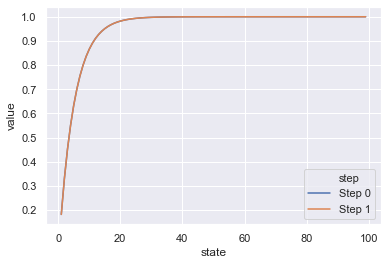

In [166]:
value_function = ValueFunction(solution)
optimizer      = ValueIteration(0.55, value_function, tolerance = 10**(-10))
optimizer.run()
optimizer.plot_value_functions()